In [1]:
# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt
import seaborn as sns
import torch
# Type hints
from typing import Callable, Union, Tuple

import os
import sys
mac_gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(mac_gems_tco_path)

# Custom imports
from GEMS_TCO import data_preprocess

from GEMS_TCO import evaluate
from GEMS_TCO import configuration as config
#from GEMS_TCO import kernels_oct25 as kernel

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd

import matplotlib.transforms as transforms

from pathlib import Path
import json
from json import JSONEncoder

# Summary

We will explore data on an hourly scale. ```The cyclic pattern``` shown in the ```semivariograms``` indicates that we should fit the data with a model that can explain this cyclic pattern.

Secondly, ```asymmetric cross-variograms``` on some days imply that there is ```space and time interaction```, hence we should consider a non-separable model.

Lastly, ```latitude-sliced``` data shows ```spatial non-stationarity```. I plan to ```detrend for 5x10 spatial points``` in the N5N10 E110E120 region.

## Quick load empirical semiovariograms from Amarel

In [2]:

year = 2024
month = 7

input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/GEMS_TCO_EDA/outputs/empirical/"
input_path = f"/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/empirical/{year}_{month:02d}/"

input_filename = "empirical_cross_lat_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    cross_lat_20000= pickle.load(pickle_file)


input_filename = "empirical_cross_lon_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    cross_lon_20000= pickle.load(pickle_file)


input_filename = "empirical_lat_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    emp_lat_20000= pickle.load(pickle_file)


input_filename = "empirical_lon_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    emp_lon_20000= pickle.load(pickle_file)


# Since you only computed positive lags, index 0 is already your Lag 0.
# You just need to overwrite the 0.0 value with None.

# 1. Process Latitude
for key in emp_lat_20000:
    if key == 0: 
        continue  # Skip the 'deltas' key
    
    # Process the list of series for this day
    for series in emp_lat_20000[key]:
        series[0] = None  # Force nugget to be empty/unknown

# 2. Process Longitude
for key in emp_lon_20000:
    if key == 0: 
        continue  # Skip the 'deltas' key
        
    for series in emp_lon_20000[key]:
        series[0] = None  # Force nugget to be empty/unknown


# Empirical directional semivariograms

empirical semivariograms

latitude 에서 날뛰는 부분 없애고 싶으면 evaluate.plot_cross_lat_empirical 가서
ax.set_xlim(0,1.8) 조정하고 가까운 거리 확대할거면  ax.set_xscale('symlog', linthresh=0.3) 조정

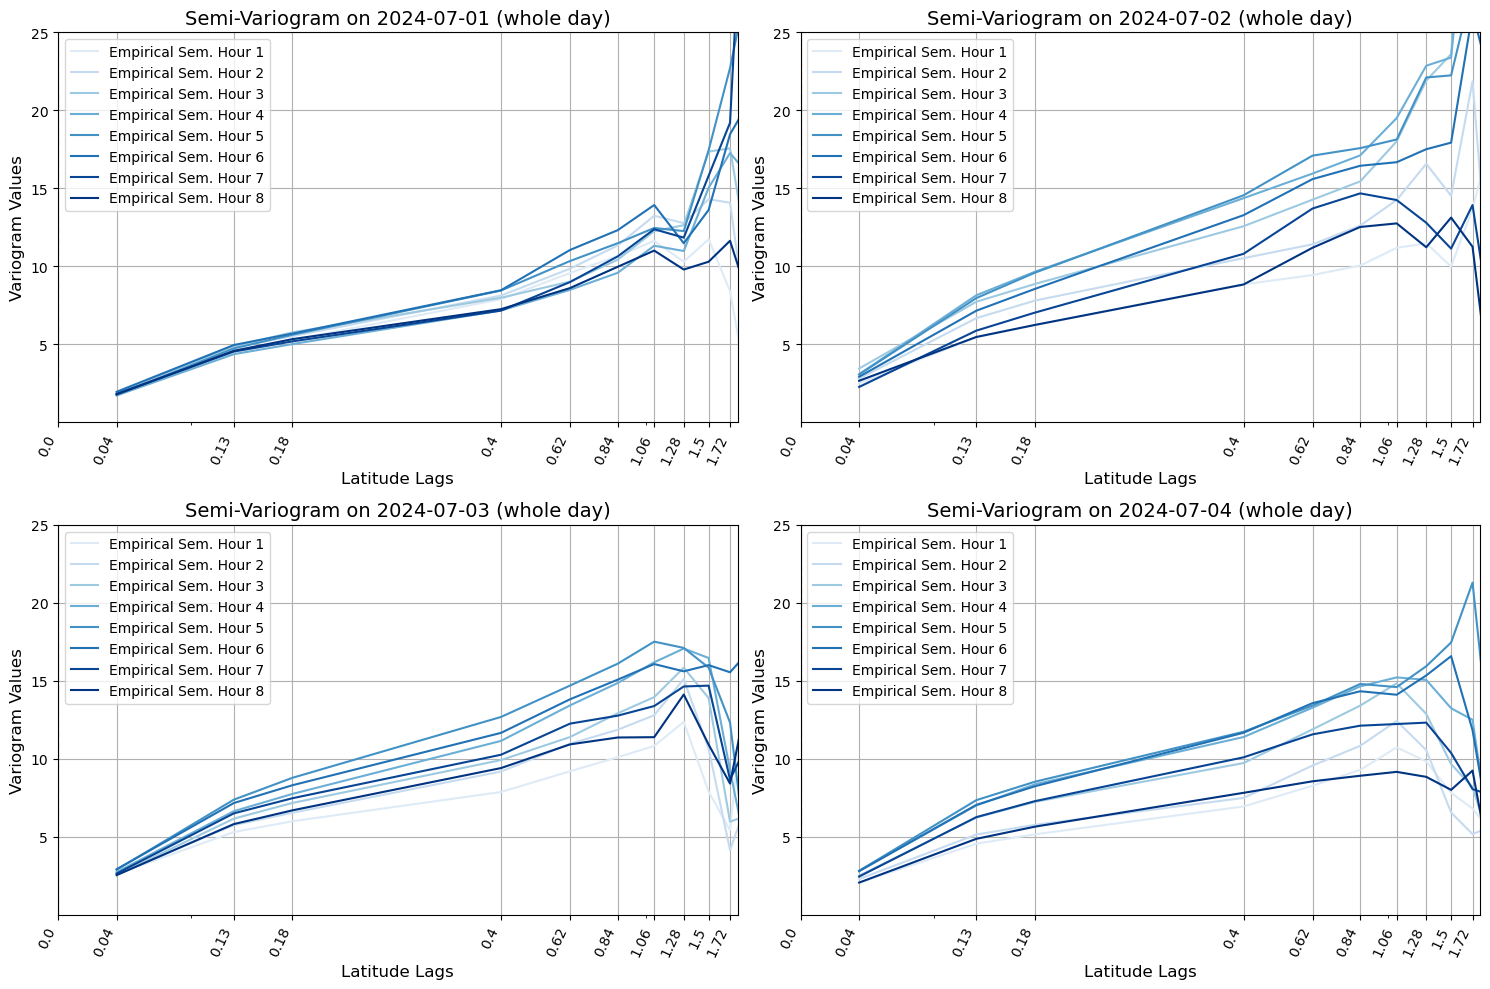

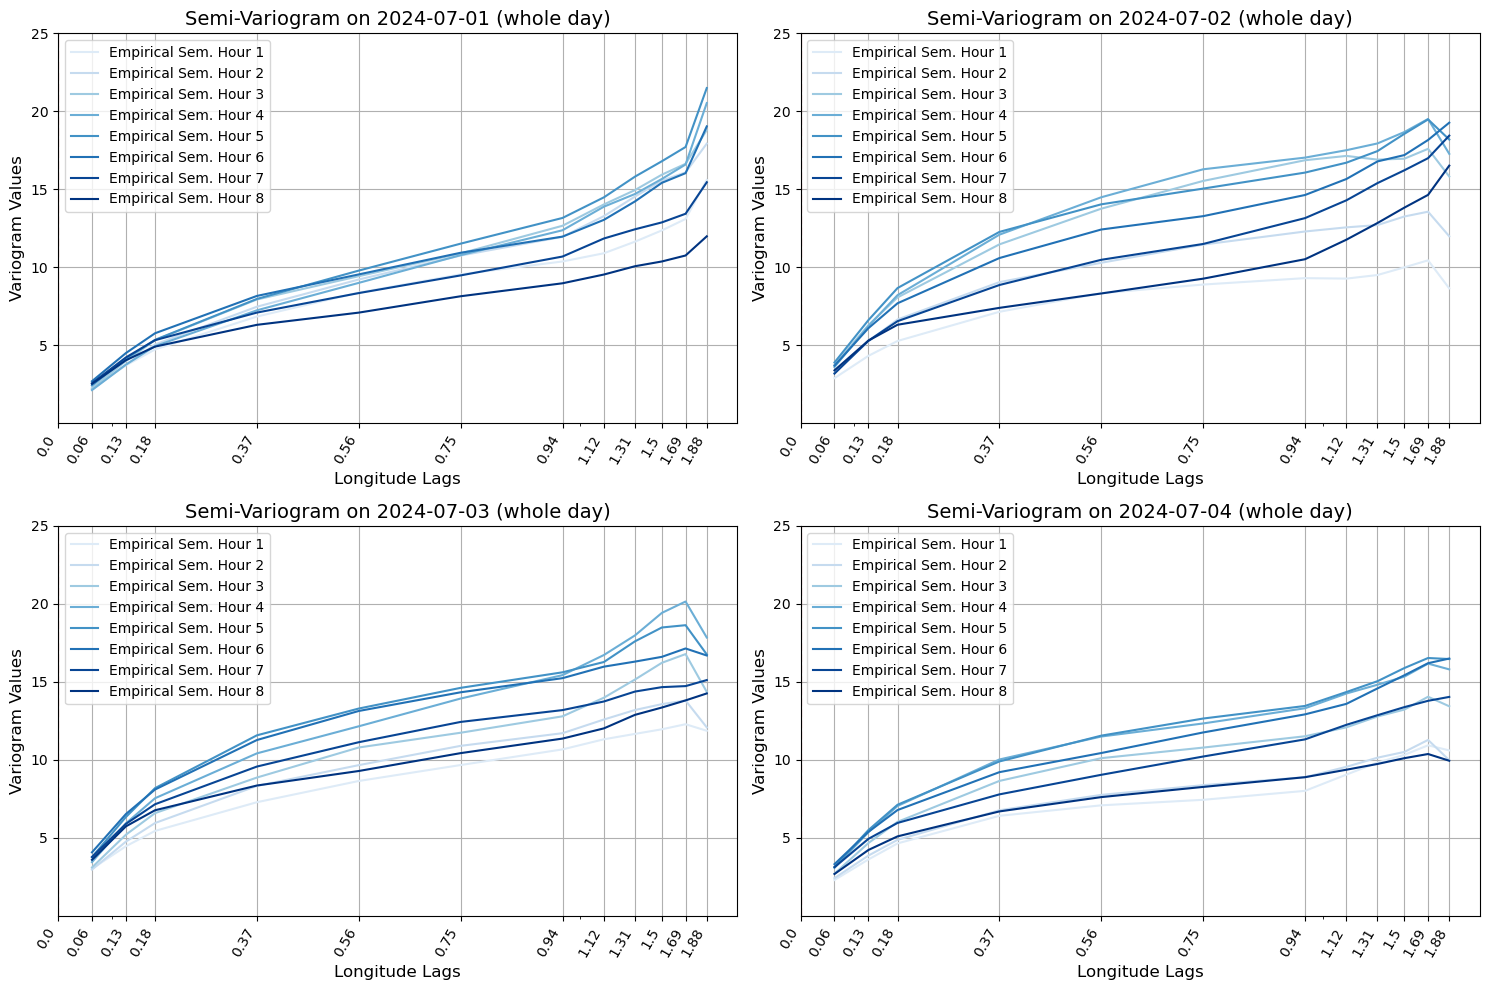

In [3]:
save_path = config.mac_save_semivariogram_path
smooth = 0.5
# length_of_analysis = f'whole day smooth {smooth:0.1f}'
length_of_analysis = f'whole day'
instance_emp_sem = evaluate.CrossVariogram_empirical(save_path, length_of_analysis,smooth)

dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[1,2,3,4]]

for days in dayss:
    instance_emp_sem.plot_lat_empirical( emp_lat_20000,days,  emp_lat_20000[0])
    instance_emp_sem.plot_lon_empirical( emp_lon_20000,days,  emp_lon_20000[0])



empirical Cross-variograms 12/25/25

latitude 에서 날뛰는 부분 없애고 싶으면 evaluate.plot_cross_lat_empirical 가서
ax.set_xlim(0,1.8) 조정하고 가까운 거리 확대할거면  ax.set_xscale('symlog', linthresh=0.3) 조정

smooth 0.5

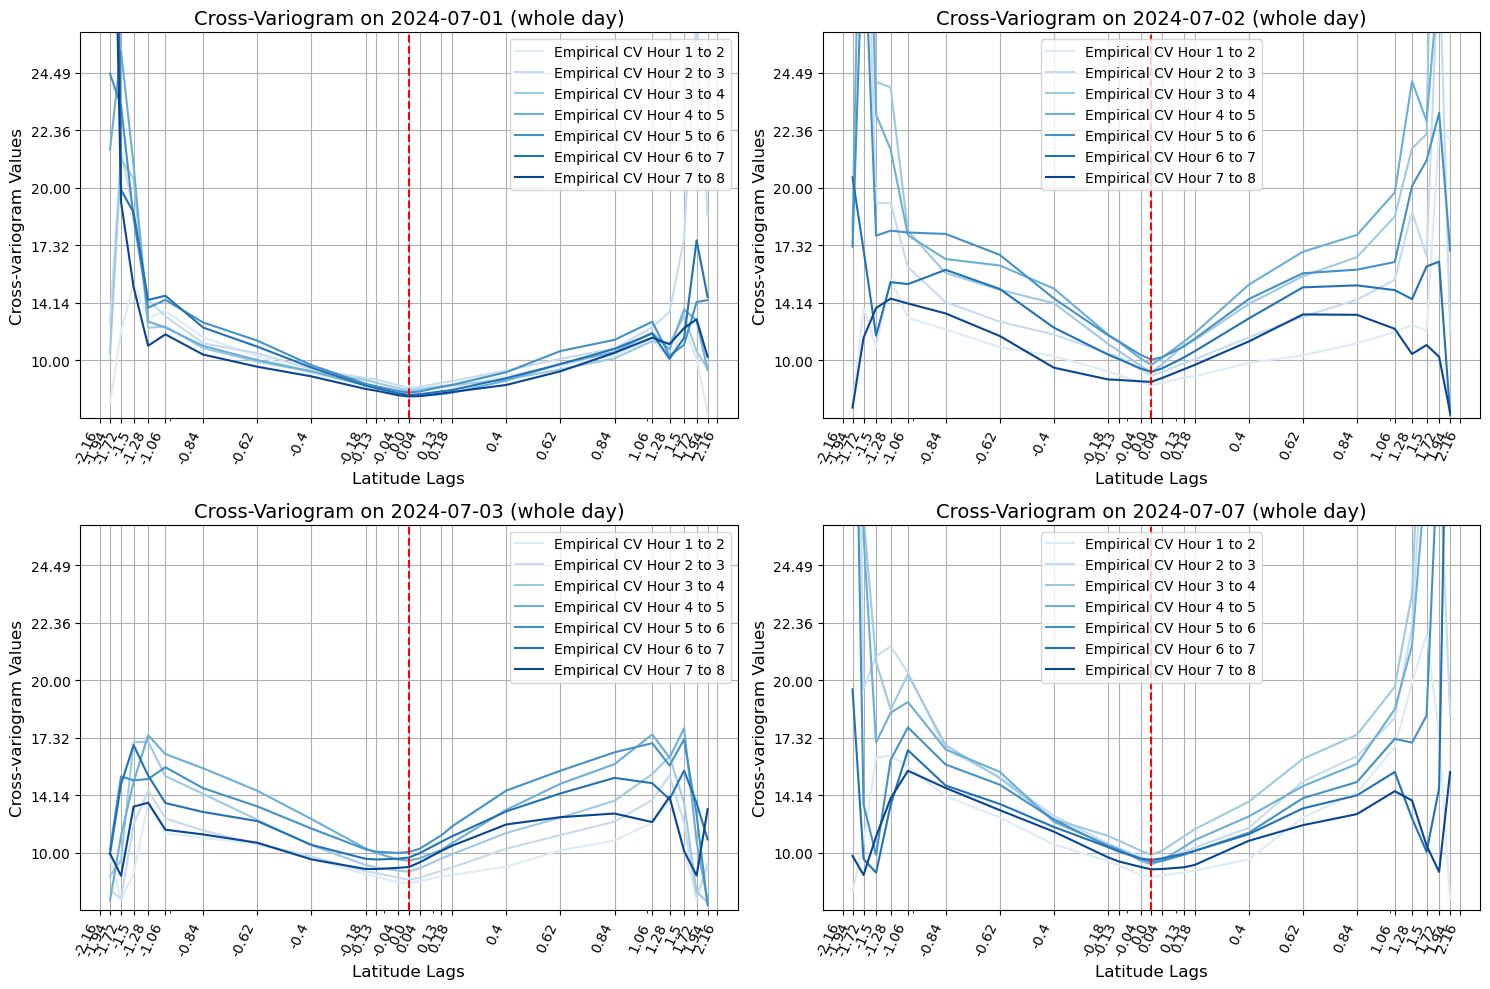

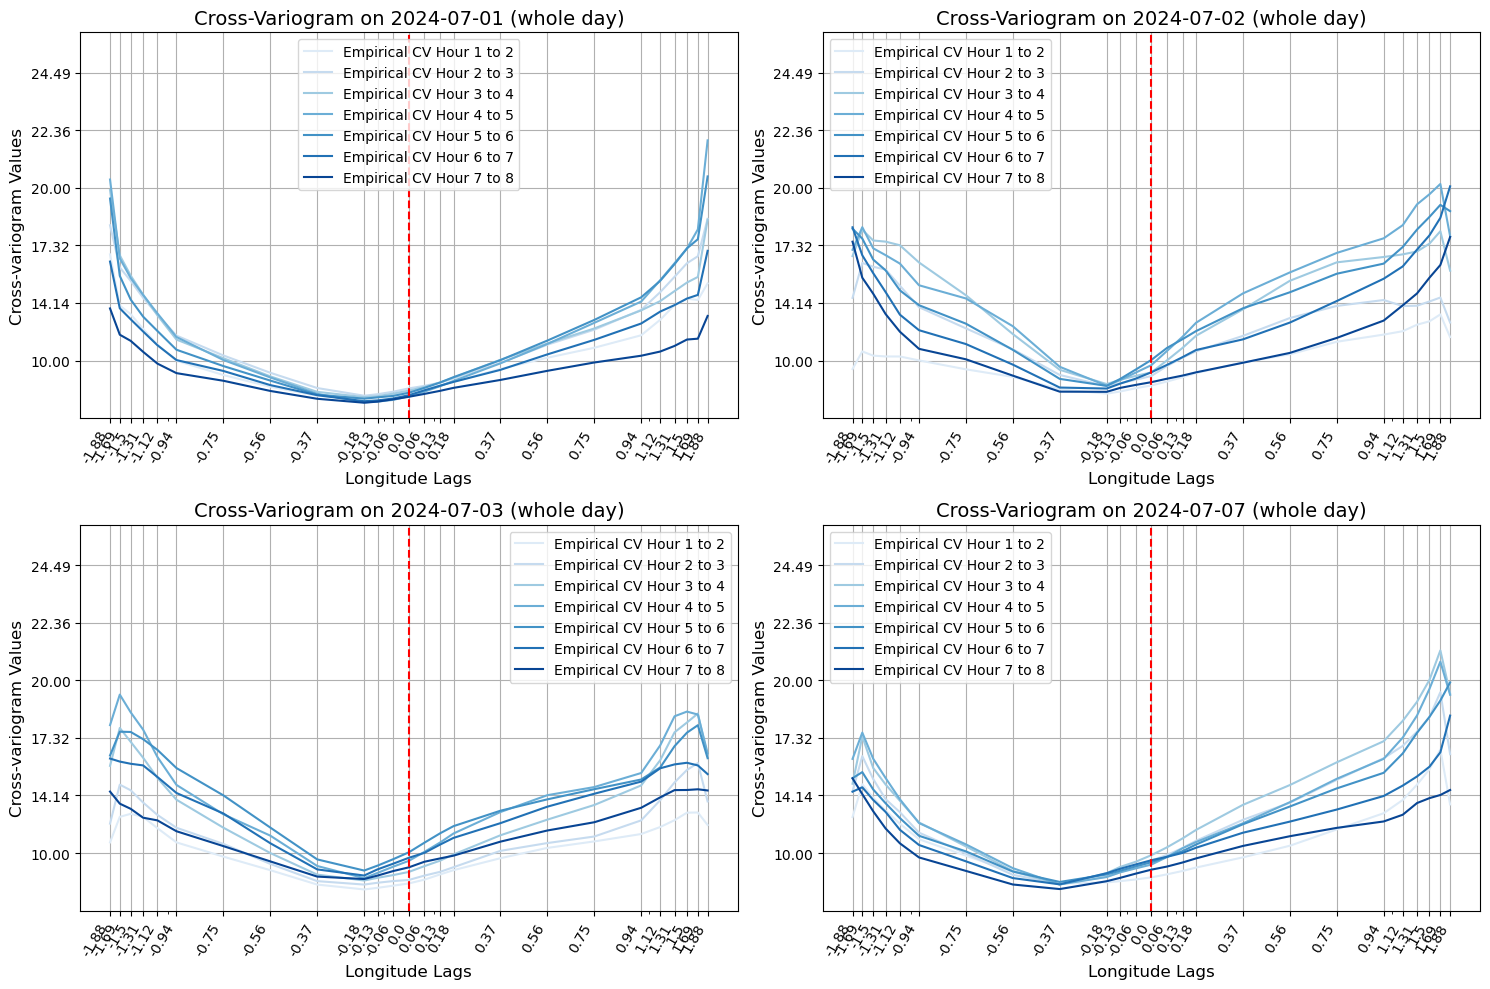

In [4]:
save_path = config.mac_save_semivariogram_path
smooth = 0.5
length_of_analysis = f'whole day'
instance_emp_sem = evaluate.CrossVariogram_empirical(save_path, length_of_analysis,smooth)

dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[1,2,3,7]]

for days in dayss:
    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_emp_sem.plot_cross_lat_empirical( cross_lat_20000,days,  cross_lat_20000[0])

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_emp_sem.plot_cross_lon_empirical( cross_lon_20000,days, cross_lon_20000[0])



# Just reference code from down below (I don't use them anymore)

# smooth 1.0

In [46]:
save_path = config.mac_save_semivariogram_path
smooth = 1.0
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_day_v10_spline1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v10 = pd.read_csv(input_filepath)  
df_full_v10 = df_full_v10.iloc[:,5:13]  

date_range = pd.date_range(start='07-01-24', end='07-31-24')
df_full_v10.index = date_range

df_full_v10


,sigma,range_lat,range_lon,advec_lat,advec_lon,beta,nugget,loss
2024-07-01,26.142,0.790,0.853,0.004,-0.114,0.269,4.337,14124.554
2024-07-02,25.707,0.824,0.796,0.041,-0.075,0.334,2.572,12421.396
2024-07-03,25.801,0.388,0.488,0.028,-0.155,0.591,2.681,15137.174
2024-07-04,26.611,0.597,0.668,-0.150,-0.207,0.301,4.116,14847.308
2024-07-05,25.310,1.106,1.380,-0.022,-0.156,0.205,3.086,12140.580
2024-07-06,24.654,0.687,1.181,0.015,-0.173,0.243,4.050,14884.526
2024-07-07,27.006,0.473,1.090,0.055,-0.339,0.268,5.153,15401.798
2024-07-08,27.742,0.530,0.902,-0.018,-0.406,0.304,4.995,14936.513
2024-07-09,26.573,0.588,1.027,0.023,-0.219,0.336,2.715,12724.811
2024-07-10,25.415,0.368,0.546,0.035,-0.104,0.526,2.942,15243.307


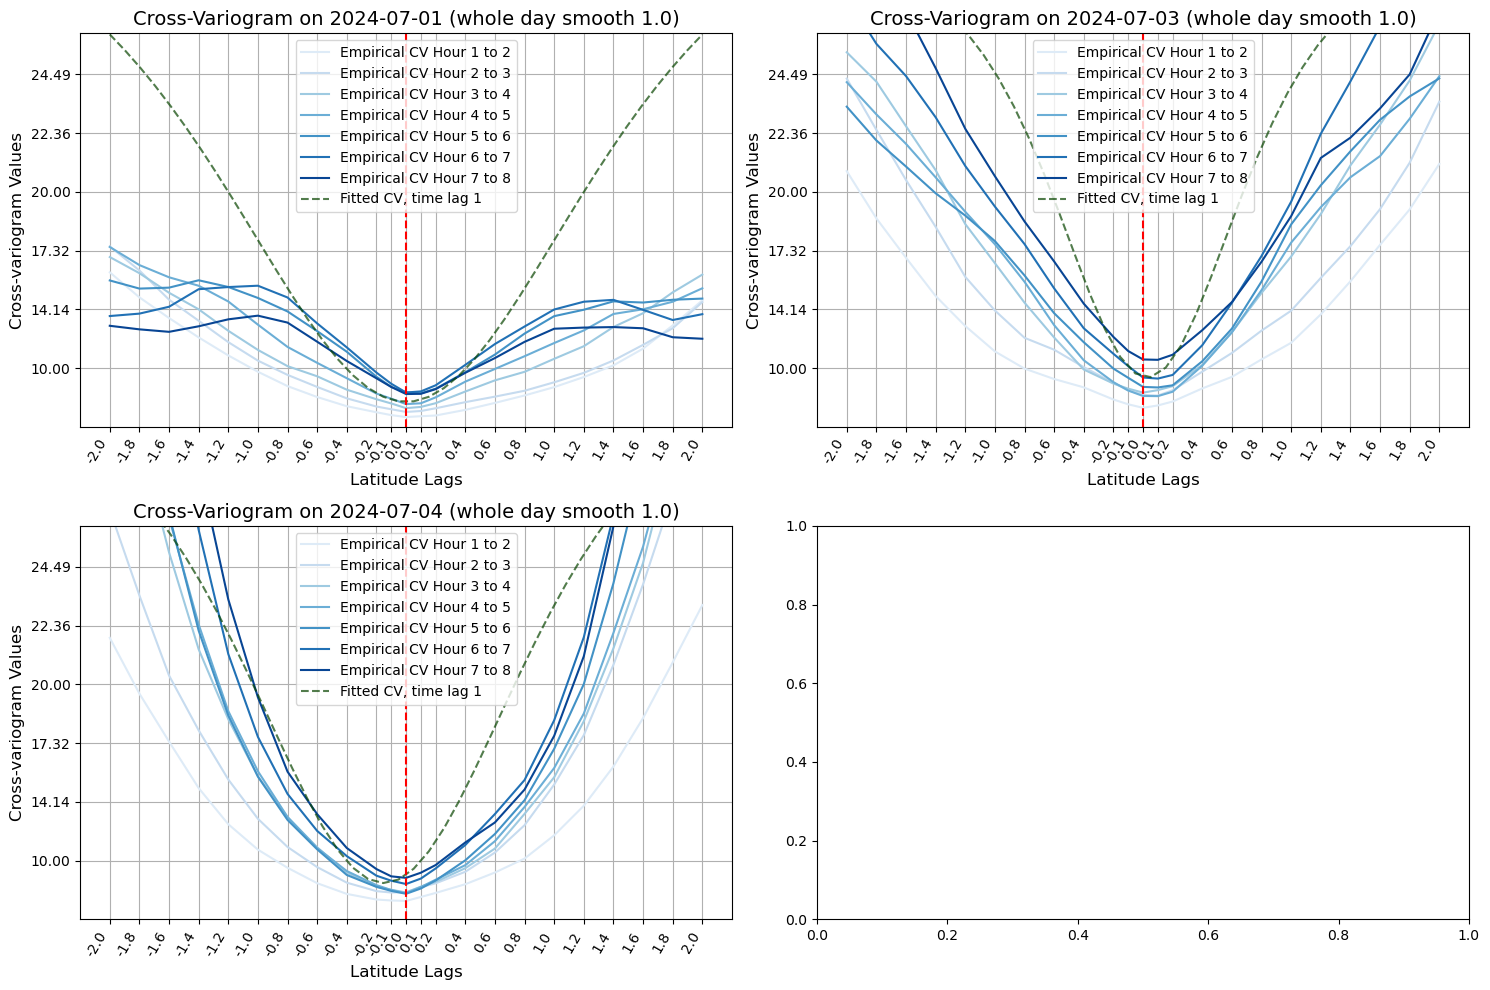

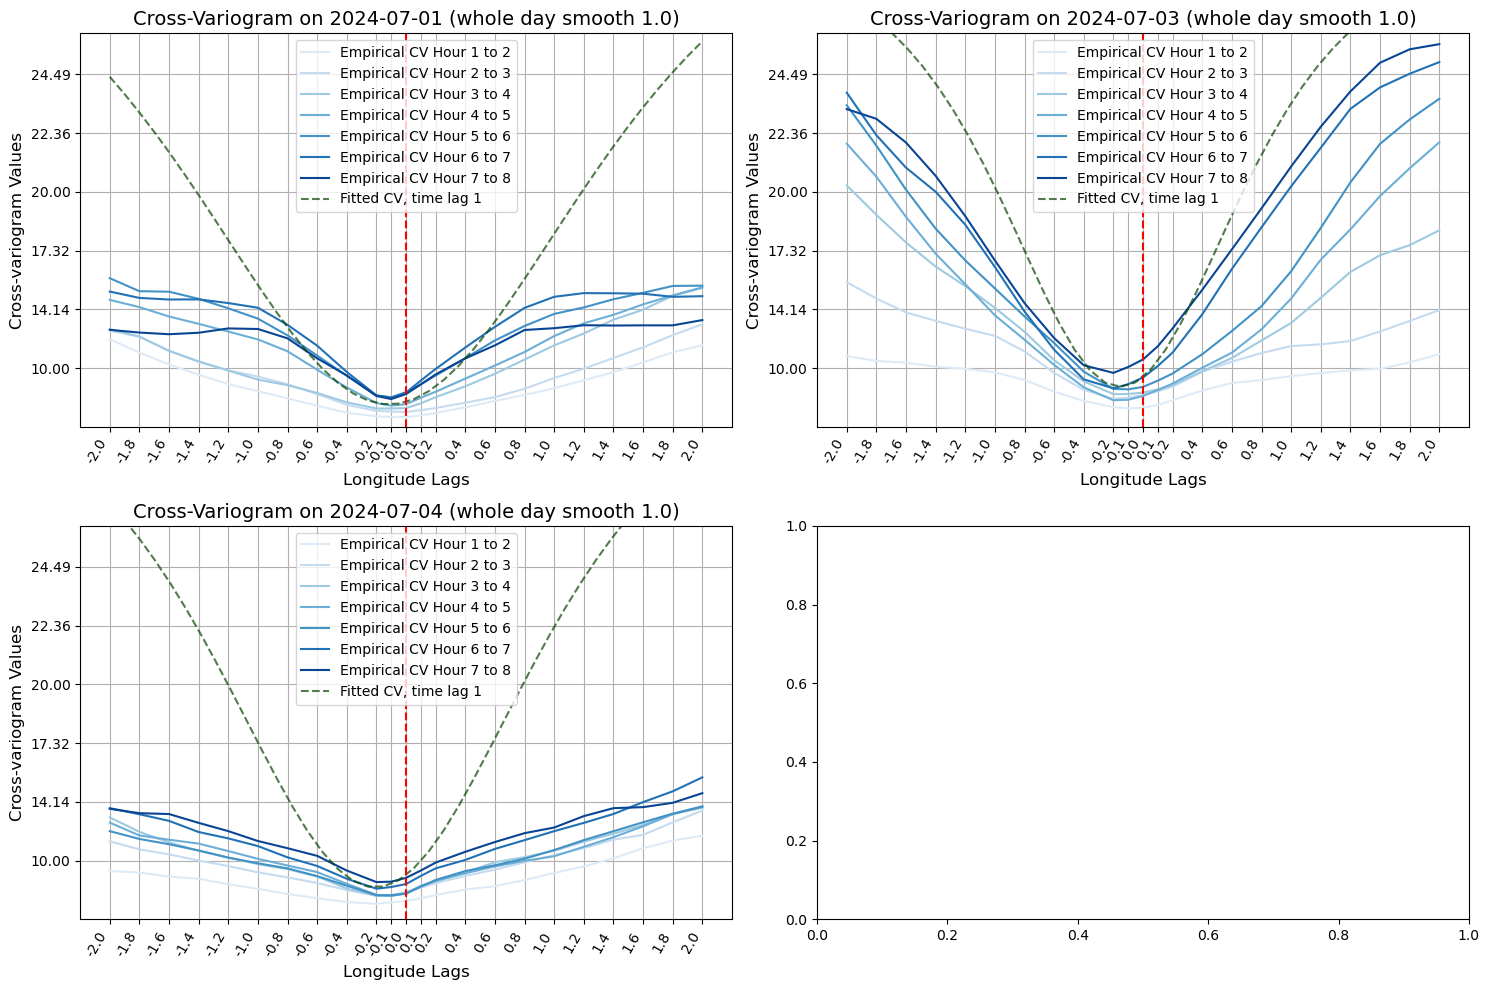

In [36]:
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[ 1,3,4]]
# df_full_v10.iloc[0] = [12.8, 0.38,0.488, 0.028, -0.155, 0.591, 2.681, 500 ]
df_full_v10.iloc[0] = [26.142, 0.79,0.853, 0.0004, -0.114, 0.269, 4.337, 500 ]
# df_full_v10.iloc[3] = [25.8, 0.797, 2.668, -0.050, -0.207, 0.301, 4.116, 500 ]

for days in dayss:
    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days, lat_lags, df_full_v10, instance_sem.theoretical_gamma_kv)
 
    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,lon_lags, df_full_v10,  instance_sem.theoretical_gamma_kv)



# smooth 1.5 

# empirical semivariogram and variances

This can help decide which model has better estimates of nuggets. If the estimated nuggets are too off from the extrapolation of first three shortest lag semiovariograms, then that might be the sign of model misspecification. 

In [ ]:
save_path = config.mac_save_semivariogram_path
smooth = 1.5
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_v15_1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)

df_full_v15 = pd.read_csv(input_filepath)
df_full_v15 = df_full_v15.iloc[:,5:13]
date_range = pd.date_range(start='07-01-24', end='07-31-24')
df_full_v15.index = date_range

dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[13,1,4,18]]

for days in dayss:

    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( cross_lat_20000,days, lat_lags, df_full_v15, instance_sem.theoretical_gamma_kv)

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( cross_lon_20000,days,lon_lags, df_full_v15, instance_sem.theoretical_gamma_kv)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates/full_v15_1250.0.csv'

# Empirical cross variograms without theoretical counterparts.

IndexError: list index out of range

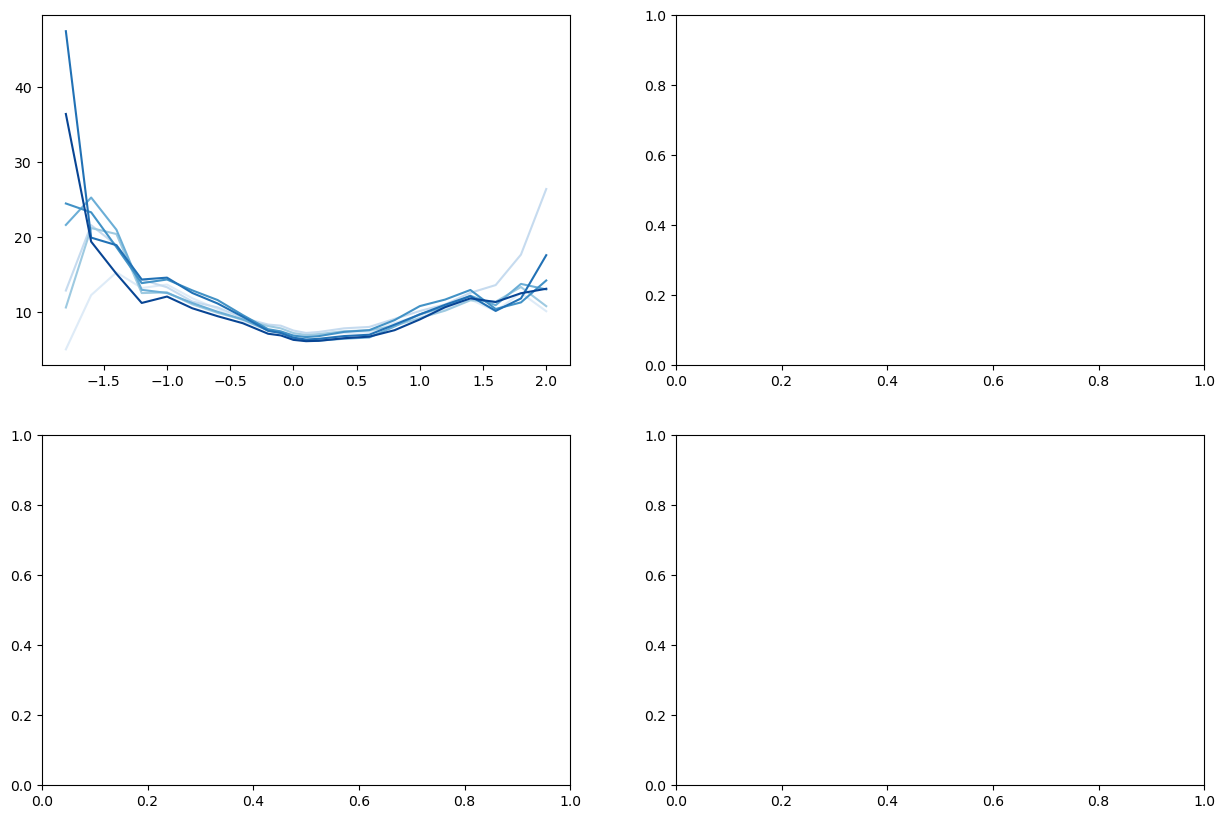

In [ ]:
save_path = config.mac_save_semivariogram_path
smooth = 0.5
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_empirical(save_path, length_of_analysis,smooth)


# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
dayss = [[1,2,3,4]]
for days in dayss:
    
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_empirical( cross_lat_20000,days, lat_lags)

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_empirical( cross_lon_20000,days,lon_lags)
    tolerance = 0.02
    d45 = np.arctan2(1,1)
    d135 = np.arctan2(-1,-1)  

    # y=x direction
    #instance_sem.plot_directional_sem_empirical(tmp, d135_45_20000, days, d135, d45)

    # y=-x direction
    #dn45 = np.arctan2(-1,1)
    #dn135 = np.arctan2(1,-1)
    #instance_sem.plot_directional_sem_empirical(tmp, dn45_n135_20000, days, dn45, dn135)


### which hours are important?

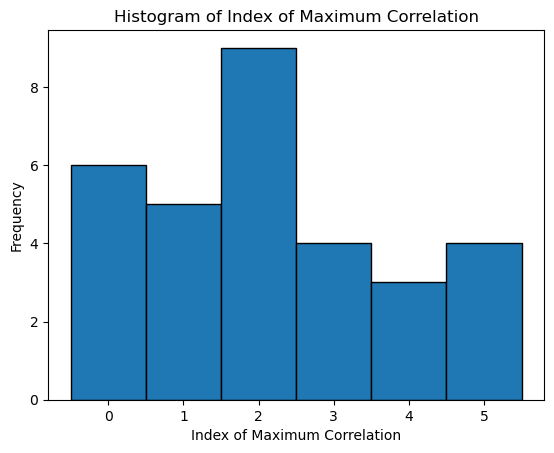

In [24]:
ssdf = cross_lon_20000
res = [] 

for j in range(1, len(ssdf)):
    tmp = []
    sdf = cross_lon_20000[j]
    for i in range(len(sdf)-1):
        # print(f'correlation between {i} and {i+1} in day {j} {np.corrcoef( sdf[i], sdf[i+1])}' )
        tmp.append( np.corrcoef( sdf[i], sdf[i+1])[0][1] )
    min_correlation_index = np.argmax(tmp)
    res.append(min_correlation_index)


plt.hist(res, bins=range(min(res), max(res) + 2), edgecolor='black', align='left')
plt.xlabel('Index of Maximum Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Index of Maximum Correlation')
plt.xticks(range(min(res), max(res) + 1))
plt.show()